[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/langchain-ai/langchain-academy/blob/main/module-1/agent-memory.ipynb) [![Open in LangChain Academy](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66e9eba12c7b7688aa3dbb5e_LCA-badge-green.svg)](https://academy.langchain.com/courses/take/intro-to-langgraph/lessons/58239417-lesson-7-agent-with-memory)

In [ ]:
%%capture --no-stderr
%pip install --quiet -U langchain_openai langchain_core langgraph

In [1]:
# import os, getpass

# def _set_env(var: str):
#     if not os.environ.get(var):
#         os.environ[var] = getpass.getpass(f"{var}: ")

# _set_env("OPENAI_API_KEY")

We'll use [LangSmith](https://docs.smith.langchain.com/) for [tracing](https://docs.smith.langchain.com/concepts/tracing).

In [2]:
# _set_env("LANGCHAIN_API_KEY")
# os.environ["LANGCHAIN_TRACING_V2"] = "true"
# import os

This follows what we did previously.

In [3]:
import os
os.environ["LANGCHAIN_PROJECT"] = "langchain-academy-debate"

from dotenv import load_dotenv

# 指定 .env 文件路径
env_path = r'C:\GitRepo\langchain-academy\module-1\.env'

# 加载 .env 文件
load_dotenv(dotenv_path=env_path)

from langchain_openai import AzureChatOpenAI

def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b

# This will be a tool
def add(a: int, b: int) -> int:
    """Adds a and b.

    Args:
        a: first int
        b: second int
    """
    return a + b

def divide(a: int, b: int) -> float:
    """Divide a and b.

    Args:
        a: first int
        b: second int
    """
    return a / b

def search_web(query: str) -> str:
    """Search the web for the query.
    
    Args:
        query: the query to search the web for
    """
    result = "上海今天大风，风力5级，阵风7级"
    return result

tools = [add, multiply, divide, search_web]
llm = AzureChatOpenAI(
    azure_deployment=os.getenv('AZURE_OPENAI_DEPLOYMENT'),
    api_version=os.getenv('AZURE_OPENAI_API_VERSION'),
    temperature=0,
    max_tokens=None,
    timeout=None,
    max_retries=2,
)
# llm_with_tools = llm.bind_tools(tools)

In [4]:
llm.invoke('hi')

AIMessage(content='Hello! How can I assist you today? 😊', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 11, 'prompt_tokens': 8, 'total_tokens': 19, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-11-20', 'system_fingerprint': 'fp_ee1d74bde0', 'id': 'chatcmpl-BMW8pvNTOUYOOPe8fQdE9Z3SLf7A2', 'prompt_filter_results': [{'prompt_index': 0, 'content_filter_results': {'hate': {'filtered': False, 'severity': 'safe'}, 'jailbreak': {'filtered': False, 'detected': False}, 'self_harm': {'filtered': False, 'severity': 'safe'}, 'sexual': {'filtered': False, 'severity': 'safe'}, 'violence': {'filtered': False, 'severity': 'safe'}}}], 'finish_reason': 'stop', 'logprobs': None, 'content_filter_results': {'hate': {'filtered': False, 'severity': 'safe'}, 'protected_material_co

In [5]:
from langgraph.graph import MessagesState
from langchain_core.messages import HumanMessage, SystemMessage

class StateWithRound(MessagesState):
    round: int
    topic: str

# System message

# Node
def user1(state: StateWithRound):
   print("*****  <<<< 拜登 >>>> node message input state <start>  *****")
   for m in state["messages"]:
      print(m.pretty_print())
   print("*****   拜登 node message input state <end>  ***** \n")

   sys_msg = SystemMessage(content="你是拜登，将和川普进行一场辩论。")

   return {"messages": [llm.invoke([sys_msg] + state["messages"])]}

# Node
def user2(state: StateWithRound):
   print("*****  <<<< 川普 >>>> node message input state <start>  *****")
   for m in state["messages"]:
      print(m.pretty_print())
   print("*****   川普 node message input state <end>  ***** \n")

   sys_msg = SystemMessage(content="你是川普，将和拜登进行一场辩论。")

   return {"messages": [llm.invoke([sys_msg] + state["messages"])]}


In [7]:
from langgraph.graph import START, StateGraph, END
from langgraph.prebuilt import tools_condition, ToolNode
from IPython.display import Image, display

# Graph
builder = StateGraph(StateWithRound)

# Define nodes: these do the work
builder.add_node("user1", user1)
builder.add_node("user2", user2)

# Define edges: these determine how the control flow moves
builder.add_edge(START, "user1")
builder.add_edge("user1", "user2")
# builder.add_conditional_edges(
#     "assistant",
#     # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
#     # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
#     tools_condition,
# )
# builder.add_edge("tools", "assistant")
builder.add_edge("user2", END)

graph = builder.compile()

# Show
# display(Image(react_graph.get_graph(xray=True).draw_mermaid_png()))

In [8]:
messages = [HumanMessage(content="评价一下中国。")]
messages = graph.invoke({"messages": messages})
for m in messages['messages']:
    m.pretty_print()

*****  <<<< 拜登 >>>> node message input state <start>  *****
================================ Human Message =================================

评价一下中国。
None
*****   拜登 node message input state <end>  ***** 

*****  <<<< 川普 >>>> node message input state <start>  *****
================================ Human Message =================================

评价一下中国。
None
================================== Ai Message ==================================

作为乔·拜登，我愿意就中国问题发表我的看法。中国是一个具有悠久历史和深厚文化底蕴的国家，同时也是一个在全球经济、科技和地缘政治中扮演重要角色的国家。我们必须以清醒的头脑看待中国，既要认识到合作的必要性，也要直面竞争的现实。

**首先，合作是不可或缺的。**  
在气候变化、全球公共卫生、核不扩散等全球性挑战上，美国和中国必须找到共同点。无论是减少碳排放还是应对新冠疫情，这些问题都超越了国界，需要世界两大经济体共同努力。

**其次，竞争必须公平。**  
中国在经济和技术领域的崛起是事实，但我们不能容忍不公平的贸易行为、知识产权盗窃以及对国际规则的破坏。美国将继续与盟友合作，确保全球经济秩序的公平性和透明性。

**第三，价值观问题不能回避。**  
我们对中国的人权问题，包括新疆、香港和言论自由的限制，始终保持关注。美国将继续为普世价值发声，捍卫民主、自由和人权。

川普总统可能会说他对中国采取了强硬立场，但事实是，他的政策更多是混乱和单边的，而不是系统性和战略性的。我们需要的是一个全面的、协调的对华政策，而不是一场关税战或推特上的口水战。

总结来说，中国是一个需要我们认真对待的竞争对手，同时也是一个在某些领域需要合作的伙伴。我们必须以智慧、团结和坚定的态度来应对这个复杂的关系，而不是靠情绪

## Memory

Let's run our agent, as before.

In [16]:
messages = [HumanMessage(content="我们之前聊了什么")]
messages = react_graph.invoke({"messages": messages})
for m in messages['messages']:
    m.pretty_print()

*****   translate node message input state <start>  *****
================================ Human Message =================================

我们之前聊了什么
None
*****   translate node message input state <end>  *****
*****   assistant node message input state <start>  *****
================================ Human Message =================================

我们之前聊了什么
None
================================== Ai Message ==================================

我们之前聊了什么？
None
*****   assistant node message input state <end>  *****


================================ Human Message =================================

我们之前聊了什么
================================== Ai Message ==================================

我们之前聊了什么？
================================== Ai Message ==================================

目前我没有上下文记录，所以无法知道我们之前聊了什么。如果你有具体的问题或想继续之前的对话，可以告诉我！


We don't retain memory of 7 from our initial chat!

This is because [state is transient](https://github.com/langchain-ai/langgraph/discussions/352#discussioncomment-9291220) to a single graph execution.

Of course, this limits our ability to have multi-turn conversations with interruptions. 

We can use [persistence](https://langchain-ai.github.io/langgraph/how-tos/persistence/) to address this! 

LangGraph can use a checkpointer to automatically save the graph state after each step.

This built-in persistence layer gives us memory, allowing LangGraph to pick up from the last state update. 

One of the easiest checkpointers to use is the `MemorySaver`, an in-memory key-value store for Graph state.

All we need to do is simply compile the graph with a checkpointer, and our graph has memory!

In [17]:
from langgraph.checkpoint.memory import MemorySaver
memory = MemorySaver()
react_graph_memory = builder.compile(checkpointer=memory)

When we use memory, we need to specify a `thread_id`.

This `thread_id` will store our collection of graph states.

Here is a cartoon:

* The checkpointer write the state at every step of the graph
* These checkpoints are saved in a thread 
* We can access that thread in the future using the `thread_id`

![state.jpg](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66e0e9f526b41a4ed9e2d28b_agent-memory2.png)


In [18]:
# Specify a thread
config = {"configurable": {"thread_id": "1"}}

# Specify an input
messages = [HumanMessage(content="今天上海天气怎么样？")]

# Run
messages = react_graph_memory.invoke({"messages": messages},config)
for m in messages['messages']:
    m.pretty_print()

*****   translate node message input state <start>  *****
================================ Human Message =================================

今天上海天气怎么样？
None
*****   translate node message input state <end>  *****
*****   assistant node message input state <start>  *****
================================ Human Message =================================

今天上海天气怎么样？
None
================================== Ai Message ==================================

今天上海天气怎么样？
None
*****   assistant node message input state <end>  *****


*****   assistant node message input state <start>  *****
================================ Human Message =================================

今天上海天气怎么样？
None
================================== Ai Message ==================================

今天上海天气怎么样？
None
================================== Ai Message ==================================
Tool Calls:
  search_web (call_DwSCnGw9LmWS7myqoMoknMD0)
 Call ID: call_DwSCnGw9LmWS7myqoMoknMD0
  Args:
    query: 今天上海天气
None
=============

If we pass the same `thread_id`, then we can proceed from from the previously logged state checkpoint! 

In this case, the above conversation is captured in the thread.

The `HumanMessage` we pass (`"Multiply that by 2."`) is appended to the above conversation.

So, the model now know that `that` refers to the `The sum of 3 and 4 is 7.`.

In [20]:
messages = [HumanMessage(content="What questions did I ask you before?")]
messages = react_graph_memory.invoke({"messages": messages}, config)
for m in messages['messages']:
    m.pretty_print()

*****   translate node message input state <start>  *****
================================ Human Message =================================

今天上海天气怎么样？
None
================================== Ai Message ==================================

今天上海天气怎么样？
None
================================== Ai Message ==================================
Tool Calls:
  search_web (call_DwSCnGw9LmWS7myqoMoknMD0)
 Call ID: call_DwSCnGw9LmWS7myqoMoknMD0
  Args:
    query: 今天上海天气
None
================================= Tool Message =================================
Name: search_web

上海今天大风，风力5级，阵风7级
None
================================== Ai Message ==================================

今天上海有大风，风力5级，阵风可达7级。外出时请注意安全，做好防风措施！
None
================================ Human Message =================================

what did we discuss before
None
================================== Ai Message ==================================

It seems I don't have any memory of our previous conversations. Could you remind me or provide s

# Multiple States

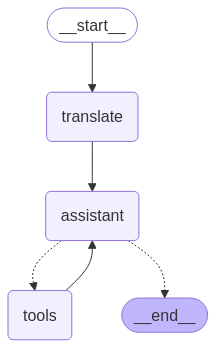

*****   <<<< translate >>>> node message input state <start>  *****
*****   <<<< translate >>>> node message input state <end>  ***** 

*****  <<<< assistant >>>> node message input state <start>  *****
================================ Human Message =================================
Name: Translator

上海的天气怎么样？
None
*****  <<<< assistant >>>> node message input state <end>  ***** 

*****  <<<< assistant >>>> node message input state <start>  *****
================================ Human Message =================================
Name: Translator

上海的天气怎么样？
None
================================== Ai Message ==================================
Tool Calls:
  search_web (call_jkYhiTJmqSIuyPYQfitRMUSh)
 Call ID: call_jkYhiTJmqSIuyPYQfitRMUSh
  Args:
    query: 上海天气
None
================================= Tool Message =================================
Name: search_web

上海今天大风，风力5级，阵风7级
None
*****  <<<< assistant >>>> node message input state <end>  ***** 

================================ Human M

In [25]:
from langgraph.graph import MessagesState
from langchain_core.messages import HumanMessage, SystemMessage

# Use MessagesState, which includes the messages key with add_messages reducer
class OverallMessagesState(MessagesState):
    # Add any keys needed beyond messages, which is pre-built 
    user_query_raw: str
    user_query_translated: str

# 翻译节点
def translate_to_chinese(state: OverallMessagesState):
   print("*****   <<<< translate >>>> node message input state <start>  *****")
   for m in state["messages"]:
        print(m.pretty_print())
   print("*****   <<<< translate >>>> node message input state <end>  ***** \n")

   sys_msg_translate = SystemMessage(content="Translate input to Chinese.")
   translator_result_msg = llm.invoke([sys_msg_translate] + [HumanMessage(content=state["user_query_raw"])] )
   translator_result_convert_user_msg = HumanMessage(content=translator_result_msg.content, name="Translator")
   return {"messages": [translator_result_convert_user_msg]
           }




# Node
def assistant(state: OverallMessagesState):
   print("*****  <<<< assistant >>>> node message input state <start>  *****")
   for m in state["messages"]:
      print(m.pretty_print())
   print("*****  <<<< assistant >>>> node message input state <end>  ***** \n")
   
   sys_msg = SystemMessage(content="You are a helpful assistant.")
   return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}




from langgraph.graph import START, StateGraph
from langgraph.prebuilt import tools_condition, ToolNode
from IPython.display import Image, display

# Graph
builder = StateGraph(OverallMessagesState)

# Define nodes: these do the work
builder.add_node("assistant", assistant)
builder.add_node("translate", translate_to_chinese)
builder.add_node("tools", ToolNode(tools))

# Define edges: these determine how the control flow moves
builder.add_edge(START, "translate")
builder.add_edge("translate", "assistant")
builder.add_conditional_edges(
    "assistant",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", "assistant")
react_graph = builder.compile()

# Show
display(Image(react_graph.get_graph(xray=True).draw_mermaid_png()))

# messages = [HumanMessage(content="How is the weather in Shanghai?")]
messages = react_graph.invoke({"user_query_raw": "How is the weather in Shanghai?"})
for m in messages['messages']:
    m.pretty_print()

In [26]:
messages

{'messages': [HumanMessage(content='上海的天气怎么样？', additional_kwargs={}, response_metadata={}, name='Translator', id='aa91676d-5547-4eb1-ad0d-6a3dd4bc7af4'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_jkYhiTJmqSIuyPYQfitRMUSh', 'function': {'arguments': '{"query":"上海天气"}', 'name': 'search_web'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 16, 'prompt_tokens': 153, 'total_tokens': 169, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-11-20', 'system_fingerprint': 'fp_ee1d74bde0', 'id': 'chatcmpl-BLmsO0R2At0ehMknH9zwQIQs9DzMa', 'prompt_filter_results': [{'prompt_index': 0, 'content_filter_results': {'hate': {'filtered': False, 'severity': 'safe'}, 'jailbreak': {'filtered': False, 'detected': False}, 'self_harm': {'filtered': False,

## LangGraph Studio

--

**⚠️ DISCLAIMER**

*Running Studio currently requires a Mac. If you are not using a Mac, then skip this step.*

--

Load the `agent` in the UI, which uses `module-1/studio/agent.py` set in `module-1/studio/langgraph.json`.